# Definition de fonctions annexes

In [1]:
def MAPE(y_mesuree, y_modelisee):
  # Erreur moyenne relative des modèles (MAPE)
  import numpy as np
  diff = (y_modelisee - y_mesuree)/y_mesuree
  mape = np.abs(diff).sum()/len(diff)*100
  return np.round(mape,1)

In [2]:
def ploy_y_ymod(y_test, Ypredit_test):


    import matplotlib.pyplot as plt
    #%matplotlib inline
    plt.figure(figsize=(5,5))
    plt.scatter(y_test, Ypredit_test, marker= 'o', s=50, alpha=0.8)
    plt.plot([0,y_test.max()], [0,y_test.max()], 'r-')
 
    plt.xlabel('mesuré')
    plt.ylabel('calculé')
    plt.axis('equal')
    plt.axis([0,y_test.max(), 0, y_test.max()])
    plt.show()

In [3]:
def plot_time_serie(data, vars_):

  import plotly.graph_objects as go

  fig = go.Figure()

  for v in vars_:
    fig.add_trace(go.Scatter(x=data[v].index, y=data[v],
                    mode='lines',
                    name=v))

  fig.show()

In [4]:
def plot_feature_weight(feat_name, feat_weight):

    import matplotlib.pyplot as plt
    import pandas as pd

    df_feat_imp = pd.DataFrame({'Poids Facteur %':100*feat_weight},index=feat_name)
    df_feat_imp.sort_values(by=['Poids Facteur %'], inplace=True)
    df_feat_imp.plot.barh(title="Importance des facteurs explicatifs")

# Lecture des données

In [5]:
file = '../Data/AmＭioration Four.xlsx'
import pandas as pd
data = pd.read_excel(file)
data.set_index("Date",inplace=True)


# Suppression NaN et calcul d'autres variables (temps de séjour, volume de gaz consommé,...)

In [6]:
import numpy as np

print('Nombre de données avant suppression des Valeurs incohérentes: ',len(data))



# somme des débits de gaz pour la préchauffe
data['PCH_DEBMOY_GAZ_TOT'] = data[['PCH_DEBMOY_GAZ_Z1','PCH_DEBMOY_GAZ_Z2','PCH_DEBMOY_GAZ_Z3']].sum(axis=1)

# Calcul du temps de séjours des bobines
import numpy as np
DT = data.index[1:] - data.index[:-1]
DT_minute = np.asarray(DT.seconds)/60
DT_minute = np.append([0.0],DT_minute)
data['Resid_Time'] = DT_minute # Temps de résidence des bobines dans le fours en minutes


data = data[((data.Resid_Time - data.Resid_Time.mean()) / data.Resid_Time.std()).abs() < 3]
data = data[((data.PCH_DEBMOY_GAZ_TOT - data.PCH_DEBMOY_GAZ_TOT.mean()) / data.PCH_DEBMOY_GAZ_TOT.std()).abs() < 3]



# Je calcul la variable 'FOU_CONSO_GAZ_GEN': Volume de gaz consommé/bobine (en Nm3)
data['FOU_CONSO_GAZ_GEN'] = data['Resid_Time']/60*data['FOU_DEBMOY_GAZ_GEN']
# On supprime les valeurs ou 'FOU_CONSO_GAZ_GEN' est =0.0
data = data.query('FOU_CONSO_GAZ_GEN > 0.0')
data = data.dropna()
# données avant les modifications
data_avt = data[data.index<='2018-08-19 06:08:10']
data['status'] = 'Avant modification'
data.loc[data.index>'2018-08-19 06:08:10', 'status'] = 'Après modification'
print('Nombre de données aprés suppression des Valeurs incohérentes: ',len(data))

Nombre de données avant suppression des Valeurs incohérentes:  21428
Nombre de données aprés suppression des Valeurs incohérentes:  21270


# Modele sur les données avant modification sur la variable volume de gaz consommé totale du four FOU_CONSO_GAZ_GEN

## Découpage des données en une partie test et une partie entrainement

In [7]:
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import t, shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels
from functions import *


predicteurs = ['EPA_ENT','LAR_ENT', 'LNG_BOB_REA','PDS_ENVOG','VIT_CEN_MOY','PCH_TMPMOY_CONS_P1']
varaexpl    = ['FOU_CONSO_GAZ_GEN']

# Variables explicatives
# X = dataset[:, :-1]

# Variable à expliquer (volume gaz général du four)
# y = dataset[:,-1]

X_train,X_test,y_train,y_test = train_test_split(data_avt[predicteurs],data_avt[varaexpl], test_size=0.25)


print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

data_train = pd.concat([X_train, y_train], axis=1)
data_test = pd.concat([X_test, y_test], axis=1)


Train (10662, 6) (10662, 1)
Test (3555, 6) (3555, 1)


In [8]:
X_train.head()

,EPA_ENT,LAR_ENT,LNG_BOB_REA,PDS_ENVOG,VIT_CEN_MOY,PCH_TMPMOY_CONS_P1
Date,,,,,,
2018-08-17 10:24:29,871.0,1507.5,1865.0,19820.0,99.77317,740.0
2018-03-15 15:50:49,859.0,1276.6,1389.0,12620.0,109.42650,700.0
2018-02-08 11:45:11,979.0,1503.0,1190.0,13660.0,103.00250,670.0
2018-05-06 07:06:20,392.0,1342.2,2345.0,9870.0,130.00000,650.0
2018-08-16 18:17:29,493.0,1343.7,2433.0,12830.0,116.74550,690.0


## Regression linéaire avec toutes les variables

In [9]:
reg_multi = smf.ols('FOU_CONSO_GAZ_GEN~EPA_ENT+LAR_ENT+LNG_BOB_REA+PDS_ENVOG+VIT_CEN_MOY+PCH_TMPMOY_CONS_P1', data=data_train).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:      FOU_CONSO_GAZ_GEN   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     4922.
Date:                Wed, 29 Jul 2020   Prob (F-statistic):               0.00
Time:                        10:44:29   Log-Likelihood:                -61890.
No. Observations:               10662   AIC:                         1.238e+05
Df Residuals:                   10655   BIC:                         1.238e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           -173.0042     23

## Regression linéaire en supprimant LNG_BOB_REA

In [10]:
reg_multi = smf.ols('FOU_CONSO_GAZ_GEN~EPA_ENT+LAR_ENT+PDS_ENVOG+VIT_CEN_MOY+PCH_TMPMOY_CONS_P1', data=data_train).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:      FOU_CONSO_GAZ_GEN   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     5903.
Date:                Wed, 29 Jul 2020   Prob (F-statistic):               0.00
Time:                        10:44:29   Log-Likelihood:                -61892.
No. Observations:               10662   AIC:                         1.238e+05
Df Residuals:                   10656   BIC:                         1.238e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           -162.7588     23

In [11]:
y_train_pred = reg_multi.predict(X_train)

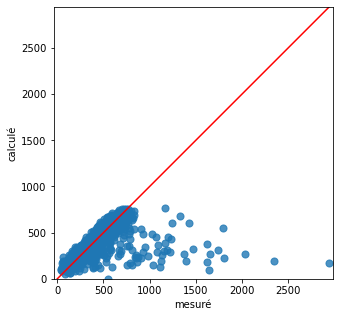

In [12]:
ploy_y_ymod(y_train.values, y_train_pred.values)

## On identifie les valeurs abbérantes sur les facteurs

Nous allons ici réaliser les tests à un niveau $\alpha=5$% :

In [13]:
alpha = 0.05

Récupérons $n$, le nombre d'individus de l'échantillon, et $p$, le nombre de variables.

In [14]:
n = data_train.shape[0]
p = 6

Nous allons mener des analyses sur les valeurs atypiques et/ou influentes en travaillant sur un dataframe appelé  analyses.

In [15]:
analyses = pd.DataFrame(index=data_train.index)
analyses['obs'] = np.arange(1, n+1)

## Calculez les leviers

On peut calculer les leviers comme ceci, en sachant que le seuil des leviers est de $2∗\frac{p}{n}$.

In [16]:
analyses['levier']   = reg_multi.get_influence().hat_matrix_diag
data_train['levier'] = analyses['levier']
seuil_levier = 2*p/n

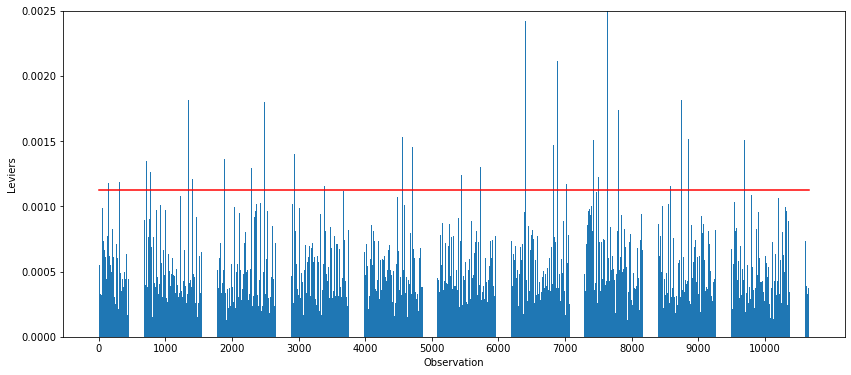

In [17]:
plt.figure(figsize=(14,6))
plt.bar(analyses['obs'], analyses['levier'])
plt.xticks(np.arange(0, n, step=1000))
plt.ylim([0,0.0025])
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, n], [seuil_levier, seuil_levier], color='r')
plt.show()

Pour sélectionner les points pour lesquels le levier est supérieur au seuil, on exécute la ligne suivante :

In [18]:
analyses.loc[analyses['levier'] > seuil_levier, :]

,obs,levier
Date,,
2018-02-06 05:53:33,18,0.001224
2018-03-29 03:16:49,36,0.001227
2018-06-26 09:45:55,58,0.001228
2018-07-12 00:03:48,89,0.003251
2018-03-18 21:55:33,124,0.001144
...,...,...
2018-02-03 17:13:07,10535,0.001335
2018-05-16 06:13:00,10581,0.001221
2018-03-14 04:10:41,10596,0.001161


## Calculez les résidus studentisés

Si l'on souhaite maintenant calculer les résidus studentisés, nous écrivons ceci, sachant que le seuil pour les résidus studentisés est une loi de Student à n-p-1 degrés de liberté :

In [19]:
analyses['rstudent'] = reg_multi.get_influence().resid_studentized_internal
data_train['rstudent'] = analyses['rstudent']
seuil_rstudent = t.ppf(1-alpha/2,n-p-1)

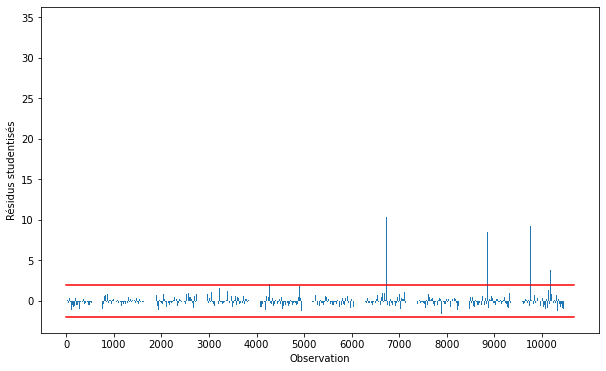

In [20]:
plt.figure(figsize=(10,6))
plt.bar(analyses['obs'], analyses['rstudent'])
plt.xticks(np.arange(0, n, step=1000))
plt.xlabel('Observation')
plt.ylabel('Résidus studentisés')
plt.plot([0, n], [seuil_rstudent, seuil_rstudent], color='r')
plt.plot([0, n], [-seuil_rstudent, -seuil_rstudent], color='r')
plt.show()

## Déterminez la distance de Cook

Pour trouver la distance de Cook, nous exécutons ceci :

In [21]:
influence = reg_multi.get_influence().summary_frame()

In [22]:
print(influence.shape)
analyses.shape

(10662, 12)


(10662, 3)

Le seuil de la distance de Cook est de n-p. 

In [23]:
influence.head()

,dfb_Intercept,dfb_EPA_ENT,dfb_LAR_ENT,dfb_PDS_ENVOG,dfb_VIT_CEN_MOY,dfb_PCH_TMPMOY_CONS_P1,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
Date,,,,,,,,,,,,
2018-08-17 10:24:29,0.004262,0.001243,-0.002461,-0.001274,0.000173,-0.004465,6.313521e-06,-0.255008,0.000582,-0.006155,-0.254997,-0.006154
2018-03-15 15:50:49,0.001505,0.000015,0.000601,0.001634,-0.000756,-0.002086,3.867819e-06,-0.398195,0.000146,-0.004817,-0.398179,-0.004817
2018-02-08 11:45:11,0.000024,0.000029,0.000114,-0.000037,0.000016,-0.000063,4.965274e-09,0.010778,0.000256,0.000173,0.010777,0.000173
2018-05-06 07:06:20,-0.000356,0.000292,-0.000045,0.000178,0.000202,0.000297,6.465223e-08,-0.030265,0.000423,-0.000623,-0.030264,-0.000623
2018-08-16 18:17:29,0.001436,-0.009621,0.000876,-0.001918,-0.006500,0.001891,2.882856e-05,0.765934,0.000295,0.013152,0.765919,0.013152


In [24]:
analyses.head()

,obs,levier,rstudent
Date,,,
2018-08-17 10:24:29,1,0.000582,-0.255008
2018-03-15 15:50:49,2,0.000146,-0.398195
2018-02-08 11:45:11,3,0.000256,0.010778
2018-05-06 07:06:20,4,0.000423,-0.030265
2018-08-16 18:17:29,5,0.000295,0.765934


In [25]:
analyses['dcooks'] = influence['cooks_d']
data_train['dcooks']= influence['cooks_d']

seuil_dcook = 4/(n-p)

In [26]:
analyses['dcooks'].mean()

0.00011356281339015667

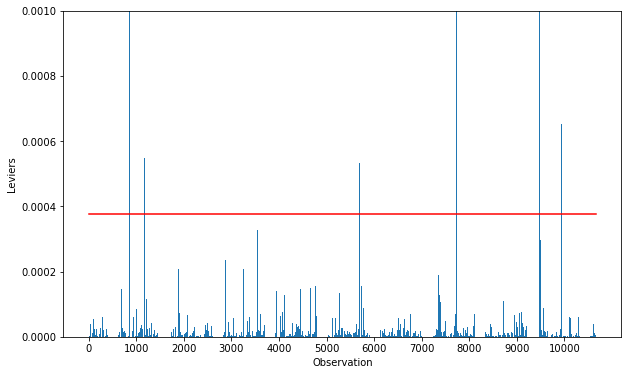

In [27]:
plt.figure(figsize=(10,6))
plt.bar(analyses['obs'], analyses['dcooks'])
plt.xticks(np.arange(0, n, step=1000))
plt.ylim([0,0.001])
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, n], [seuil_dcook, seuil_dcook], color='r')
plt.show()

In [28]:
#analyses.loc[analyses['levier'] > seuil_levier, :] 
analyses.loc[analyses['rstudent'] > seuil_rstudent, :]

,obs,levier,rstudent,dcooks
Date,,,,
2018-07-01 04:15:13,13,0.001080,7.519111,0.010192
2018-03-02 08:44:46,91,0.000981,8.001079,0.010479
2018-03-25 09:19:46,268,0.000426,7.633256,0.004135
2018-05-18 10:49:03,292,0.000920,2.134661,0.000700
2018-03-02 15:34:39,304,0.000278,3.735281,0.000646
...,...,...,...,...
2018-06-15 11:56:12,10235,0.000846,5.567098,0.004374
2018-03-30 07:35:01,10304,0.000846,2.363222,0.000788
2018-04-20 15:38:58,10307,0.000657,4.613831,0.002332


# On ne retire des points qu'après avoir vérifié qu'ils sont effectivement atypiques, voire aberrants, au vu du modèle estimé.

In [29]:
data_train_clean = data_train[(data_train.levier < seuil_levier)]

print('Nombre de données avant suppression des Leviers: ',len(data_train))
print('Nombre de données aprés suppression des Leviers: ',len(data_train_clean))

data_train_clean2 = data_train_clean[(data_train_clean.rstudent < seuil_rstudent) & (data_train_clean.rstudent > -seuil_rstudent) ]


print('Nombre de données avant suppression des teststu: ',len(data_train_clean))
print('Nombre de données aprés suppression des teststu: ',len(data_train_clean2))

data_train_clean3 = data_train_clean2[(data_train_clean2.dcooks < seuil_dcook)]

print('Nombre de données avant test distance de cook: ',len(data_train_clean2))
print('Nombre de données aprés test distance de cook: ',len(data_train_clean3))


Nombre de données avant suppression des Leviers:  10662
Nombre de données aprés suppression des Leviers:  10282
Nombre de données avant suppression des teststu:  10282
Nombre de données aprés suppression des teststu:  10199
Nombre de données avant test distance de cook:  10199
Nombre de données aprés test distance de cook:  10184


# Recursive facteur elimination avec RFE

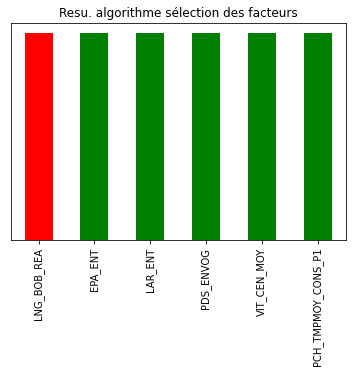

In [30]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

init_facteur = ['LNG_BOB_REA','EPA_ENT', 'LAR_ENT', 'PDS_ENVOG', 'VIT_CEN_MOY', 'PCH_TMPMOY_CONS_P1']

linreg = LinearRegression()
selector = RFE(linreg, n_features_to_select=5, step=1)
selector = selector.fit(data_train_clean3[init_facteur], data_train_clean3['FOU_CONSO_GAZ_GEN'])



from matplotlib.pyplot import *

fig, ax = subplots()
#df = pd.DataFrame({'A':26, 'B':20}, index=['N'])
#df.plot(kind='bar', ax=ax)


colours = {True: "g", False: "r"}

v_feat = [1 for f in selector.support_]

df = pd.DataFrame({'V':v_feat,'Is':selector.support_},index=init_facteur)


df['V'].plot(
    kind="bar", 
    color=df['Is'].replace(colours),
    yticks=[],
    ax=ax,
    title='Resu. algorithme sélection des facteurs'
);



# Identification de l'importance des facteurs avec un arbre de décision en supprimant "LNG_BOB_REA"

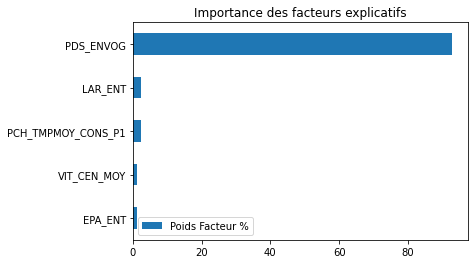

In [31]:
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(data_train_clean3[['EPA_ENT', 'LAR_ENT', 'PDS_ENVOG', 'VIT_CEN_MOY', 'PCH_TMPMOY_CONS_P1']], data_train_clean3['FOU_CONSO_GAZ_GEN'])
feat_name = ['EPA_ENT', 'LAR_ENT', 'PDS_ENVOG', 'VIT_CEN_MOY', 'PCH_TMPMOY_CONS_P1']
feat_weight = regressor.feature_importances_

plot_feature_weight(feat_name,feat_weight )

# Vérifier la colinéarité des facteurs explicatifs

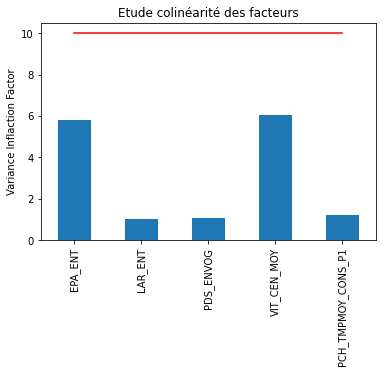

In [32]:
reg_multi = smf.ols('FOU_CONSO_GAZ_GEN~EPA_ENT+LAR_ENT+PDS_ENVOG+VIT_CEN_MOY+PCH_TMPMOY_CONS_P1', data=data_train_clean3).fit()
variables = reg_multi.model.exog
vif = [variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]
exog_names=['EPA_ENT','LAR_ENT','PDS_ENVOG','VIT_CEN_MOY','PCH_TMPMOY_CONS_P1']
df = pd.DataFrame({'VIF':vif},index=exog_names)

fig, ax = subplots()


g = df['VIF'].plot(
    kind="bar", 
    ax=ax,
    title='Etude colinéarité des facteurs'
);

ax.plot([0, 4], [10, 10], color='r');
plt.ylabel('Variance Inflaction Factor');

# On réeffectue la regression avec les données nettoyées

R2= 0.9361237033354464


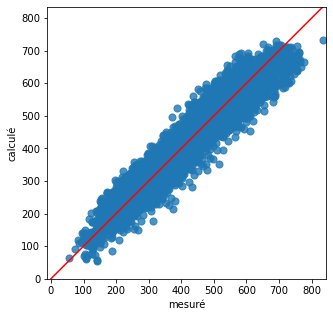

In [33]:
model_reglin = smf.ols('FOU_CONSO_GAZ_GEN~EPA_ENT+LAR_ENT+PDS_ENVOG+VIT_CEN_MOY+PCH_TMPMOY_CONS_P1', data=data_train_clean3).fit()


y_mes = data_train_clean3['FOU_CONSO_GAZ_GEN'].values
y_mod = model_reglin.predict(data_train_clean3[['EPA_ENT', 'LAR_ENT', 'PDS_ENVOG', 'VIT_CEN_MOY', 'PCH_TMPMOY_CONS_P1']])

print('R2=',model_reglin.rsquared)
ploy_y_ymod(y_mes, y_mod.values)

## Testez l’homoscédasticité

On peut également tester l’homoscédasticité (c'est-à-dire la constance de la variance) des résidus :

In [34]:
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(reg_multi.resid, variables)
print('p value test Breusch Pagan:', pval)

p value test Breusch Pagan: 8.402717088522285e-125


La p-valeur ici n'est inférieure à $5$%, rejette donc l'hypothèse $H0$ selon laquelle les variances sont constantes (l'hypothèse d’homoscédasticité).

## Testez la normalité des résidus

Si l'on veut tester la normalité des résidus, on peut faire un test de Shapiro-Wilk.

In [35]:
shapiro(reg_multi.resid)

c:\users\33623\pycharmprojects\testregressionlineaire\venv\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.9912617802619934, pvalue=1.6999512717558144e-24)

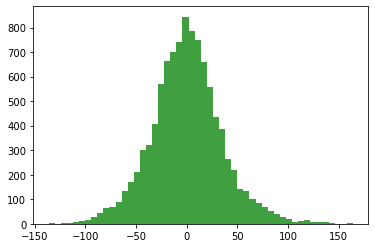

In [36]:
import matplotlib.pyplot as plt

plt.hist(reg_multi.resid.values, 50, facecolor='green', alpha=0.75)

plt.show()

R2= 0.9347382490070058


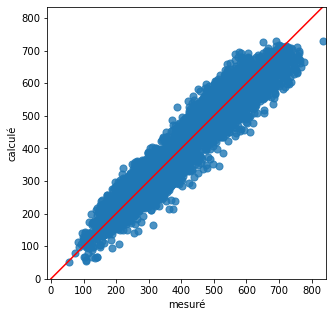

In [37]:
y_mes = data_train_clean3['FOU_CONSO_GAZ_GEN'].values

reg_multi = smf.ols('FOU_CONSO_GAZ_GEN~LAR_ENT+PDS_ENVOG+PCH_TMPMOY_CONS_P1', data=data_train_clean3).fit()


y_mod = reg_multi.predict(data_train_clean3[['LAR_ENT', 'PDS_ENVOG', 'PCH_TMPMOY_CONS_P1']])

print('R2=',reg_multi.rsquared)
ploy_y_ymod(y_mes, y_mod.values)


## Regression régularisée

In [38]:
import statsmodels.api as sm


model = sm.OLS(data_train_clean3['FOU_CONSO_GAZ_GEN'], data_train_clean3[['LNG_BOB_REA','EPA_ENT', 'LAR_ENT', 'PDS_ENVOG', 'VIT_CEN_MOY', 'PCH_TMPMOY_CONS_P1']])

results_fr = model.fit_regularized(L1_wt=0, alpha=0.1)
print(results_fr)

In [39]:
data_train_clean3.head()

,EPA_ENT,LAR_ENT,LNG_BOB_REA,PDS_ENVOG,VIT_CEN_MOY,PCH_TMPMOY_CONS_P1,FOU_CONSO_GAZ_GEN,levier,rstudent,dcooks
Date,,,,,,,,,,
2018-08-17 10:24:29,871.0,1507.5,1865.0,19820.0,99.77317,740.0,474.954219,0.000582,-0.255008,6.313521e-06
2018-03-15 15:50:49,859.0,1276.6,1389.0,12620.0,109.42650,700.0,283.578887,0.000146,-0.398195,3.867819e-06
2018-02-08 11:45:11,979.0,1503.0,1190.0,13660.0,103.00250,670.0,307.765624,0.000256,0.010778,4.965274e-09
2018-05-06 07:06:20,392.0,1342.2,2345.0,9870.0,130.00000,650.0,220.257157,0.000423,-0.030265,6.465223e-08
2018-08-16 18:17:29,493.0,1343.7,2433.0,12830.0,116.74550,690.0,380.301128,0.000295,0.765934,2.882856e-05


In [40]:
from sklearn import linear_model
import numpy as np
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
n_alphas = 300
alphas = np.logspace(-5, 10, n_alphas)
ridge = linear_model.Ridge()
baseline_error = []

dataset = data_avt[['EPA_ENT', 'LAR_ENT', 'PDS_ENVOG', 'VIT_CEN_MOY', 'PCH_TMPMOY_CONS_P1','FOU_CONSO_GAZ_GEN']].values
# Variables explicatives
X_test = dataset[:, :-1]

y_test = dataset[:,-1]




X_test_scaled  = scaler.fit_transform(X_test)

coefs = []
errors = []
for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X_test_scaled, y_test)
    coefs.append(ridge.coef_)
    errors.append(np.mean((ridge.predict(X_test_scaled) - y_test) ** 2))

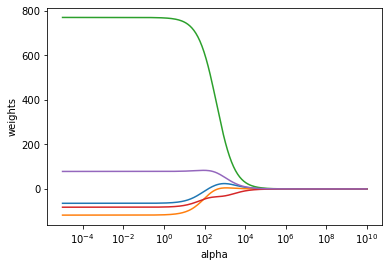

In [41]:
import matplotlib.pyplot as plt

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.axis('tight')
plt.show()

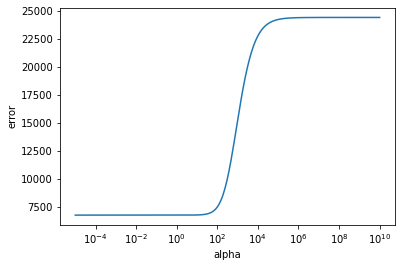

In [42]:
import matplotlib.pyplot as plt

ax = plt.gca()

ax.plot(alphas, errors)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('error')
plt.axis('tight')
plt.show()

## Algorithme de sélection des modèles

In [43]:
from sklearn import linear_model
import numpy as np



dataset = data_avt[['LNG_BOB_REA','EPA_ENT', 'LAR_ENT', 'PDS_ENVOG', 'VIT_CEN_MOY', 'PCH_TMPMOY_CONS_P1','FOU_CONSO_GAZ_GEN']].values
# Variables explicatives
X = dataset[:, :-1]

y = dataset[:,-1]

# normalize data as done by Lars to allow for comparison
X /= np.sqrt(np.sum(X ** 2, axis=0))


Text(0.5, 1.0, 'Information-criterion for model selection (training time 0.000s)')

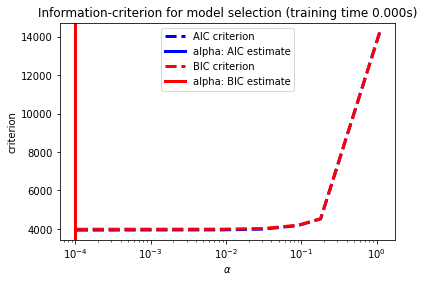

In [44]:
# #############################################################################
# LassoLarsIC: least angle regression with BIC/AIC criterion
import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
model_bic = LassoLarsIC(criterion='bic')
t1 = time.time()
model_bic.fit(X, y)
t_bic = time.time() - t1
alpha_bic_ = model_bic.alpha_

model_aic = LassoLarsIC(criterion='aic')
model_aic.fit(X, y)
alpha_aic_ = model_aic.alpha_
EPSILON = 1e-4

def plot_ic_criterion(model, name, color):
    criterion_ = model.criterion_
    plt.semilogx(model.alphas_ + EPSILON, criterion_, '--', color=color,
                 linewidth=3, label='%s criterion' % name)
    plt.axvline(model.alpha_ + EPSILON, color=color, linewidth=3,
                label='alpha: %s estimate' % name)
    plt.xlabel(r'$\alpha$')
    plt.ylabel('criterion')


plt.figure()
plot_ic_criterion(model_aic, 'AIC', 'b')
plot_ic_criterion(model_bic, 'BIC', 'r')
plt.legend()
plt.title('Information-criterion for model selection (training time %.3fs)'
          % t_bic)






Computing regularization path using the coordinate descent lasso...
Computing regularization path using the Lars lasso...


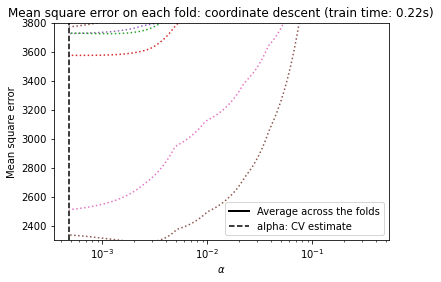

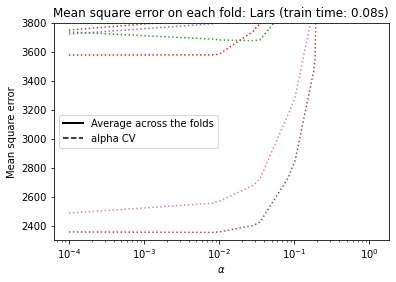

In [45]:
# #############################################################################
# LassoCV: coordinate descent

# Compute paths
print("Computing regularization path using the coordinate descent lasso...")
t1 = time.time()
model = LassoCV(cv=20).fit(X, y)
t_lasso_cv = time.time() - t1

# Display results
plt.figure()
ymin, ymax = 2300, 3800
plt.semilogx(model.alphas_ + EPSILON, model.mse_path_, ':')
plt.plot(model.alphas_ + EPSILON, model.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(model.alpha_ + EPSILON, linestyle='--', color='k',
            label='alpha: CV estimate')

plt.legend()

plt.xlabel(r'$\alpha$')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold: coordinate descent '
          '(train time: %.2fs)' % t_lasso_cv)
plt.axis('tight')
plt.ylim(ymin, ymax)

# #############################################################################
# LassoLarsCV: least angle regression

# Compute paths
print("Computing regularization path using the Lars lasso...")
t1 = time.time()
model = LassoLarsCV(cv=20).fit(X, y)
t_lasso_lars_cv = time.time() - t1

# Display results
plt.figure()
plt.semilogx(model.cv_alphas_ + EPSILON, model.mse_path_, ':')
plt.semilogx(model.cv_alphas_ + EPSILON, model.mse_path_.mean(axis=-1), 'k',
             label='Average across the folds', linewidth=2)
plt.axvline(model.alpha_, linestyle='--', color='k',
            label='alpha CV')
plt.legend()

plt.xlabel(r'$\alpha$')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold: Lars (train time: %.2fs)'
          % t_lasso_lars_cv)
plt.axis('tight')
plt.ylim(ymin, ymax)

plt.show()